In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [5]:
raw_logs = pd.read_csv('train_logs.csv')

# Create 80/20 train/test split, ensuring the same 'id' is kept in each set
unique_ids = raw_logs['id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train = raw_logs[raw_logs['id'].isin(train_ids)]
test = raw_logs[raw_logs['id'].isin(test_ids)]

train.to_csv('train_logs_grouped.csv', index=False)
test.to_csv('test_logs_grouped.csv', index=False)

In [2]:
def aggregate_user_logs(data):
    # Group 'Move From [x1, y1] To [x2, y2]' activities as 'Move From To'
    data['activity_processed'] = data['activity'].replace(
        to_replace=r'^Move From \[\d+, \d+\] To \[\d+, \d+\]$', value='Move From To', regex=True)

    # Group by user ID
    grouped = data.groupby('id')

    # Calculate latest uptime - earliest downtime
    time_spent = grouped.apply(lambda x: x['up_time'].max() - x['down_time'].min()).rename('time_worked')

    # Calculate average action time
    avg_action_time = grouped['action_time'].mean().rename('avg_action_time')

    # Count occurrences of each activity type
    activity_counts = grouped['activity_processed'].value_counts().unstack(fill_value=0)

    # Count the number of "q"s and special characters in text_change
    count_letters = grouped['text_change'].apply(lambda x: x.str.count('q').sum()).rename('count_letters')
    count_special_chars = grouped['text_change'].apply(lambda x: x.str.count('[^q]').sum()).rename('count_special_chars')

    # Get final word count
    final_word_count = grouped['word_count'].max().rename('final_word_count')

    # Combine all aggregations
    result = pd.concat([time_spent, avg_action_time, activity_counts, count_letters, count_special_chars, final_word_count], axis=1)

    return result

In [6]:
# Aggregate the training data
aggregated_train_data = aggregate_user_logs(train)

# aggregated_train_data.to_csv('train_logs_aggregated.csv', index=False)
print(aggregated_train_data.head())

/var/folders/c0/b_j0bjyx5732dw26p0d6q9nc0000gn/T/ipykernel_82089/1374656544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['activity_processed'] = data['activity'].replace(


          time_worked  avg_action_time  Input  Move From To  Nonproduction  \
id                                                                           
001519c8      1797443       116.246774   2010             3            120   
0022f953      1758346       112.221271   1938             0            254   
0042269b      1767228       101.837766   3515             0            175   
0059420b      1363074       121.848329   1304             0             99   
0075873a      1584002       123.943896   1942             0             72   

          Paste  Remove/Cut  Replace  count_letters  count_special_chars  \
id                                                                         
001519c8      0         417        7           2016                 1489   
0022f953      1         260        1           1705                 2538   
0042269b      0         439        7           3675                 2210   
0059420b      1         151        1           1168                 1108 

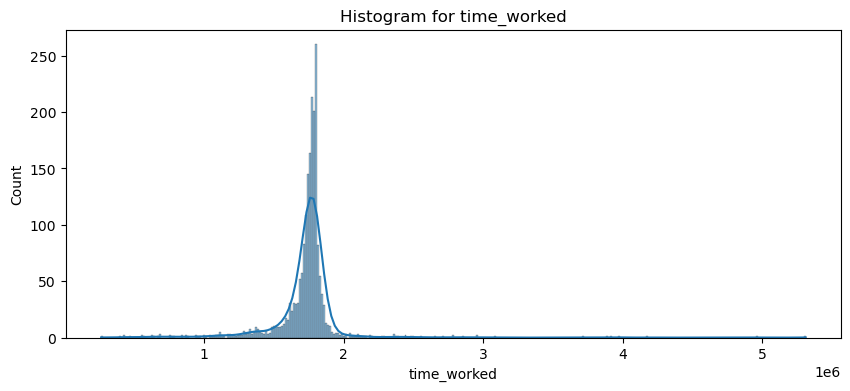

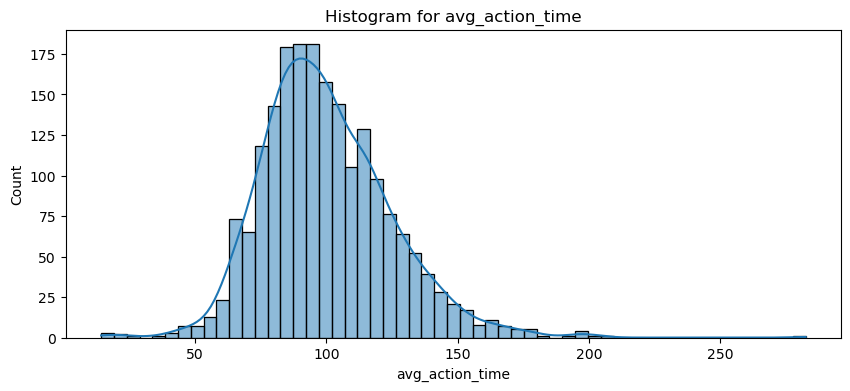

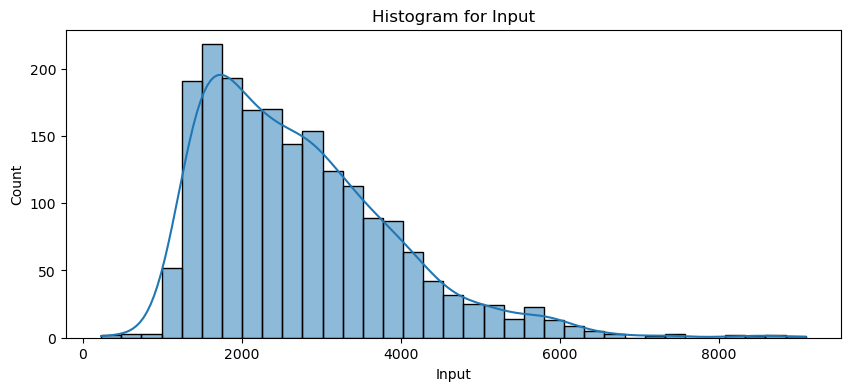

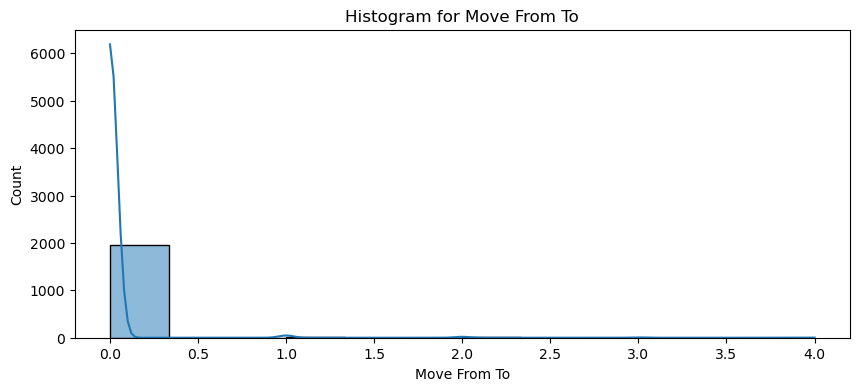

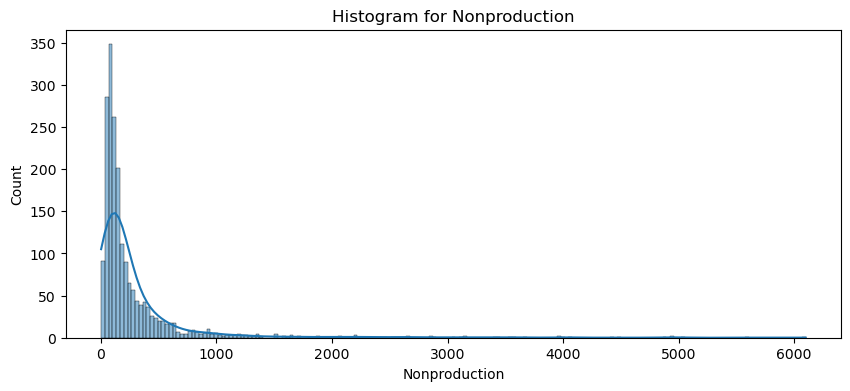

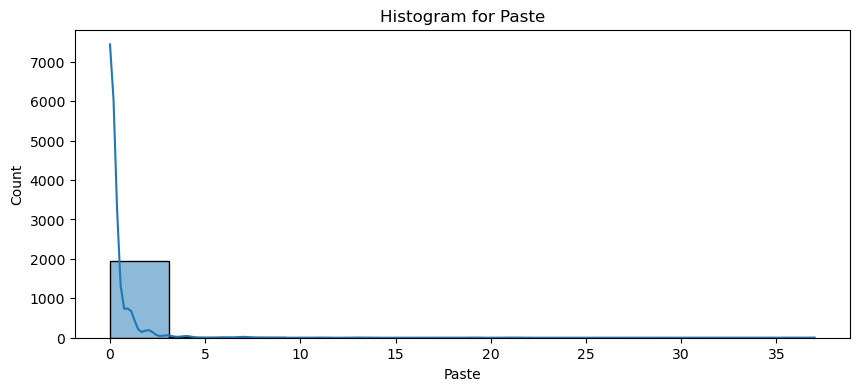

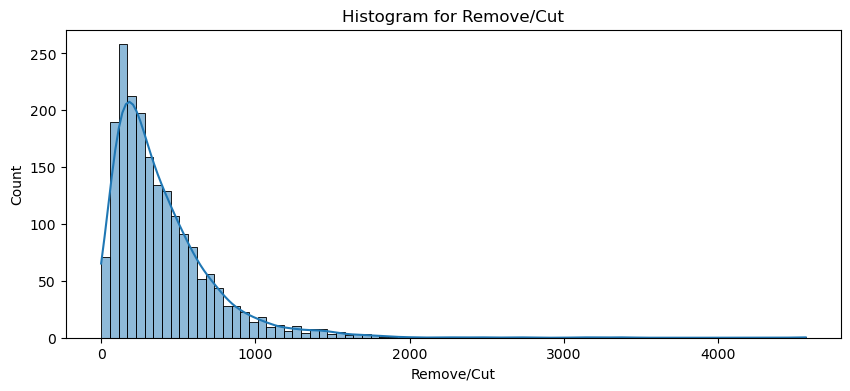

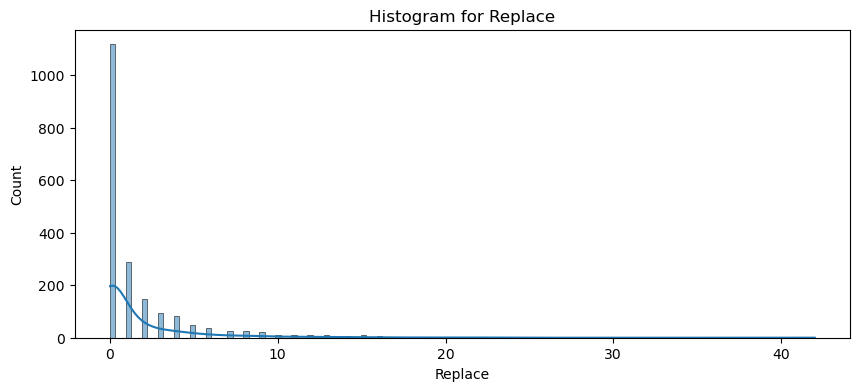

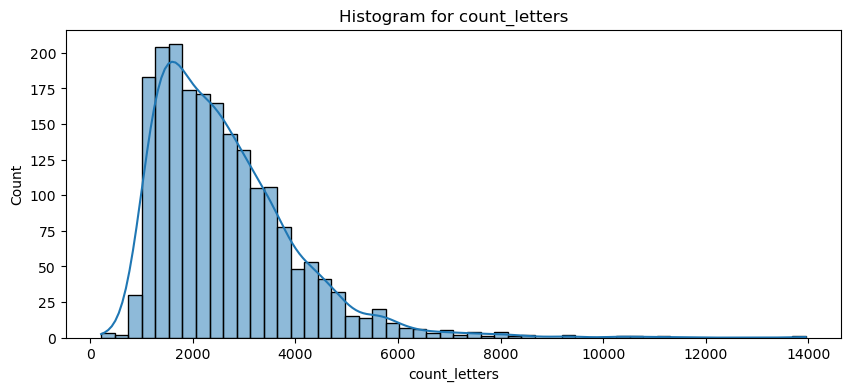

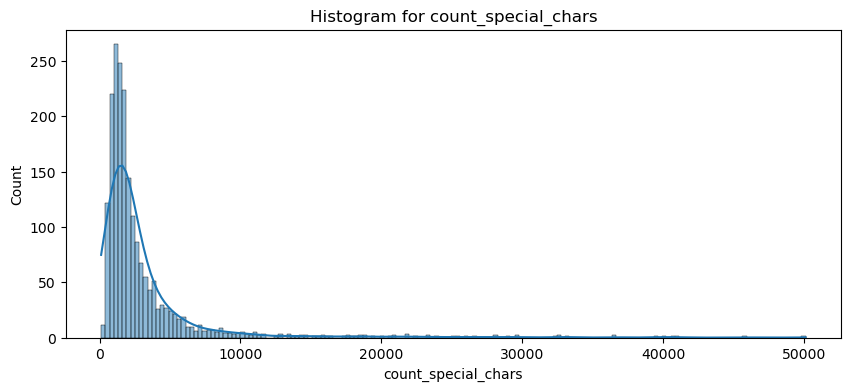

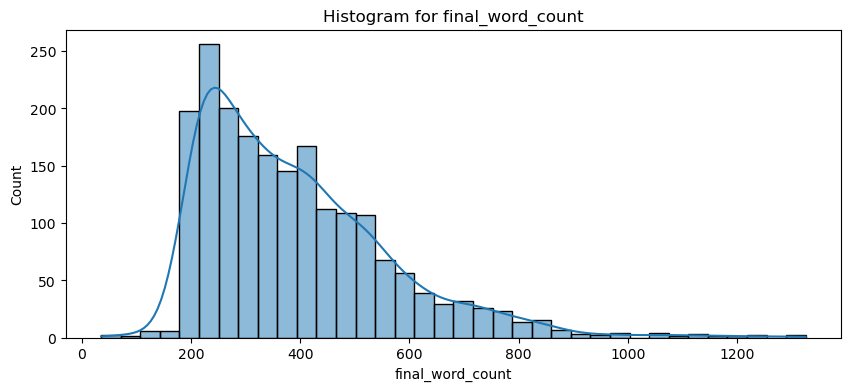

Summary of all variables:
        time_worked  avg_action_time        Input  Move From To  \
count  1.976000e+03      1976.000000  1976.000000   1976.000000   
mean   1.730794e+06        99.960906  2723.941802      0.018725   
std    2.563929e+05        24.580941  1201.373838      0.191341   
min    2.598510e+05        14.131749   230.000000      0.000000   
25%    1.705422e+06        83.416385  1780.750000      0.000000   
50%    1.761772e+06        96.805660  2496.500000      0.000000   
75%    1.795404e+06       114.573862  3386.000000      0.000000   
max    5.311131e+06       282.612447  9091.000000      4.000000   

       Nonproduction        Paste   Remove/Cut      Replace  count_letters  \
count    1976.000000  1976.000000  1976.000000  1976.000000    1976.000000   
mean      291.527328     0.251012   393.424595     1.805668    2618.110830   
std       535.995163     1.302675   342.270093     3.722758    1336.823235   
min         2.000000     0.000000     0.000000     0.00000

In [7]:
numerical_columns = aggregated_train_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(aggregated_train_data[col], kde=True)
    plt.title(f"Histogram for {col}")
    plt.show()

# 3. Summary of All Variables
print("Summary of all variables:")
print(aggregated_train_data.describe())


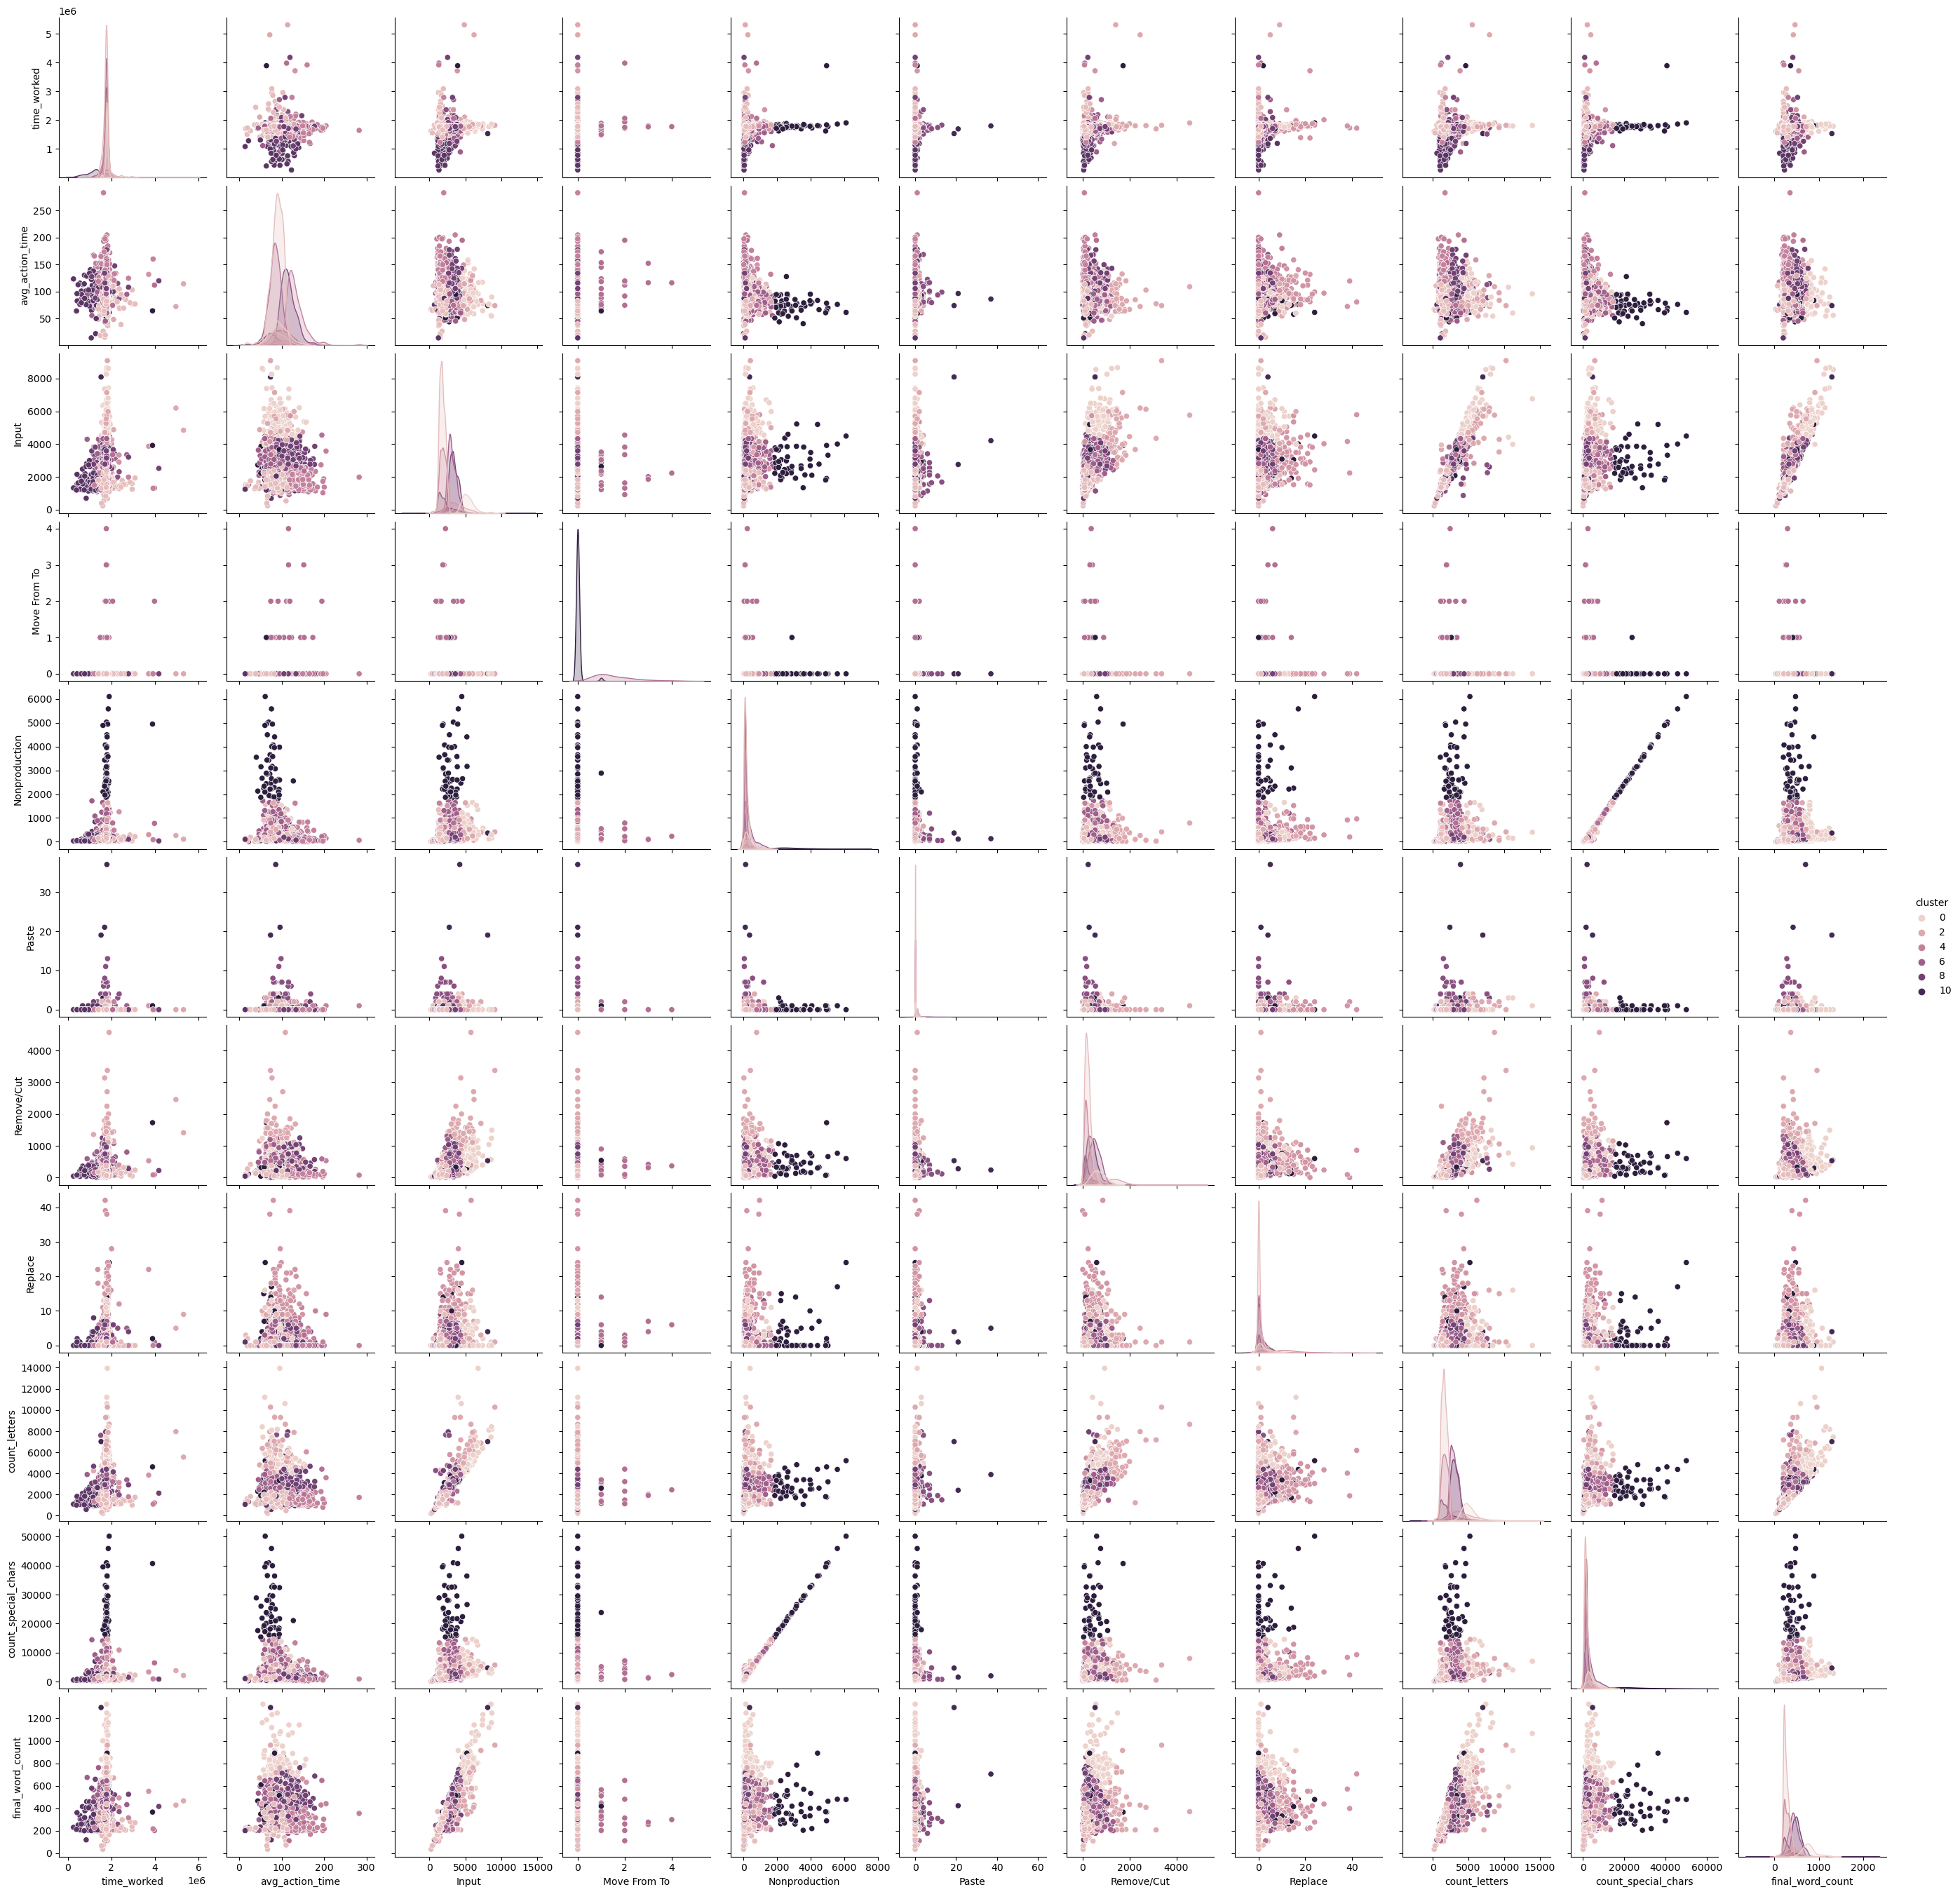

In [13]:

# get aggregated_train_data features
features = aggregated_train_data.to_numpy()

# Standardize the features (important for k-means)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create a k-means model with 7 clusters
kmeans = KMeans(n_clusters=12, random_state=42)

# Fit the model
kmeans.fit(features_scaled)

# Predict the cluster for each data point
clusters = kmeans.predict(features_scaled)

# Add the cluster assignments to your original dataframe
aggregated_train_data['cluster'] = clusters

# Save the data with cluster labels
aggregated_train_data.to_csv('clustered_data.csv', index=False)

# Plot the clusters for all variables
sns.pairplot(aggregated_train_data, hue='cluster')


/Users/rj/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


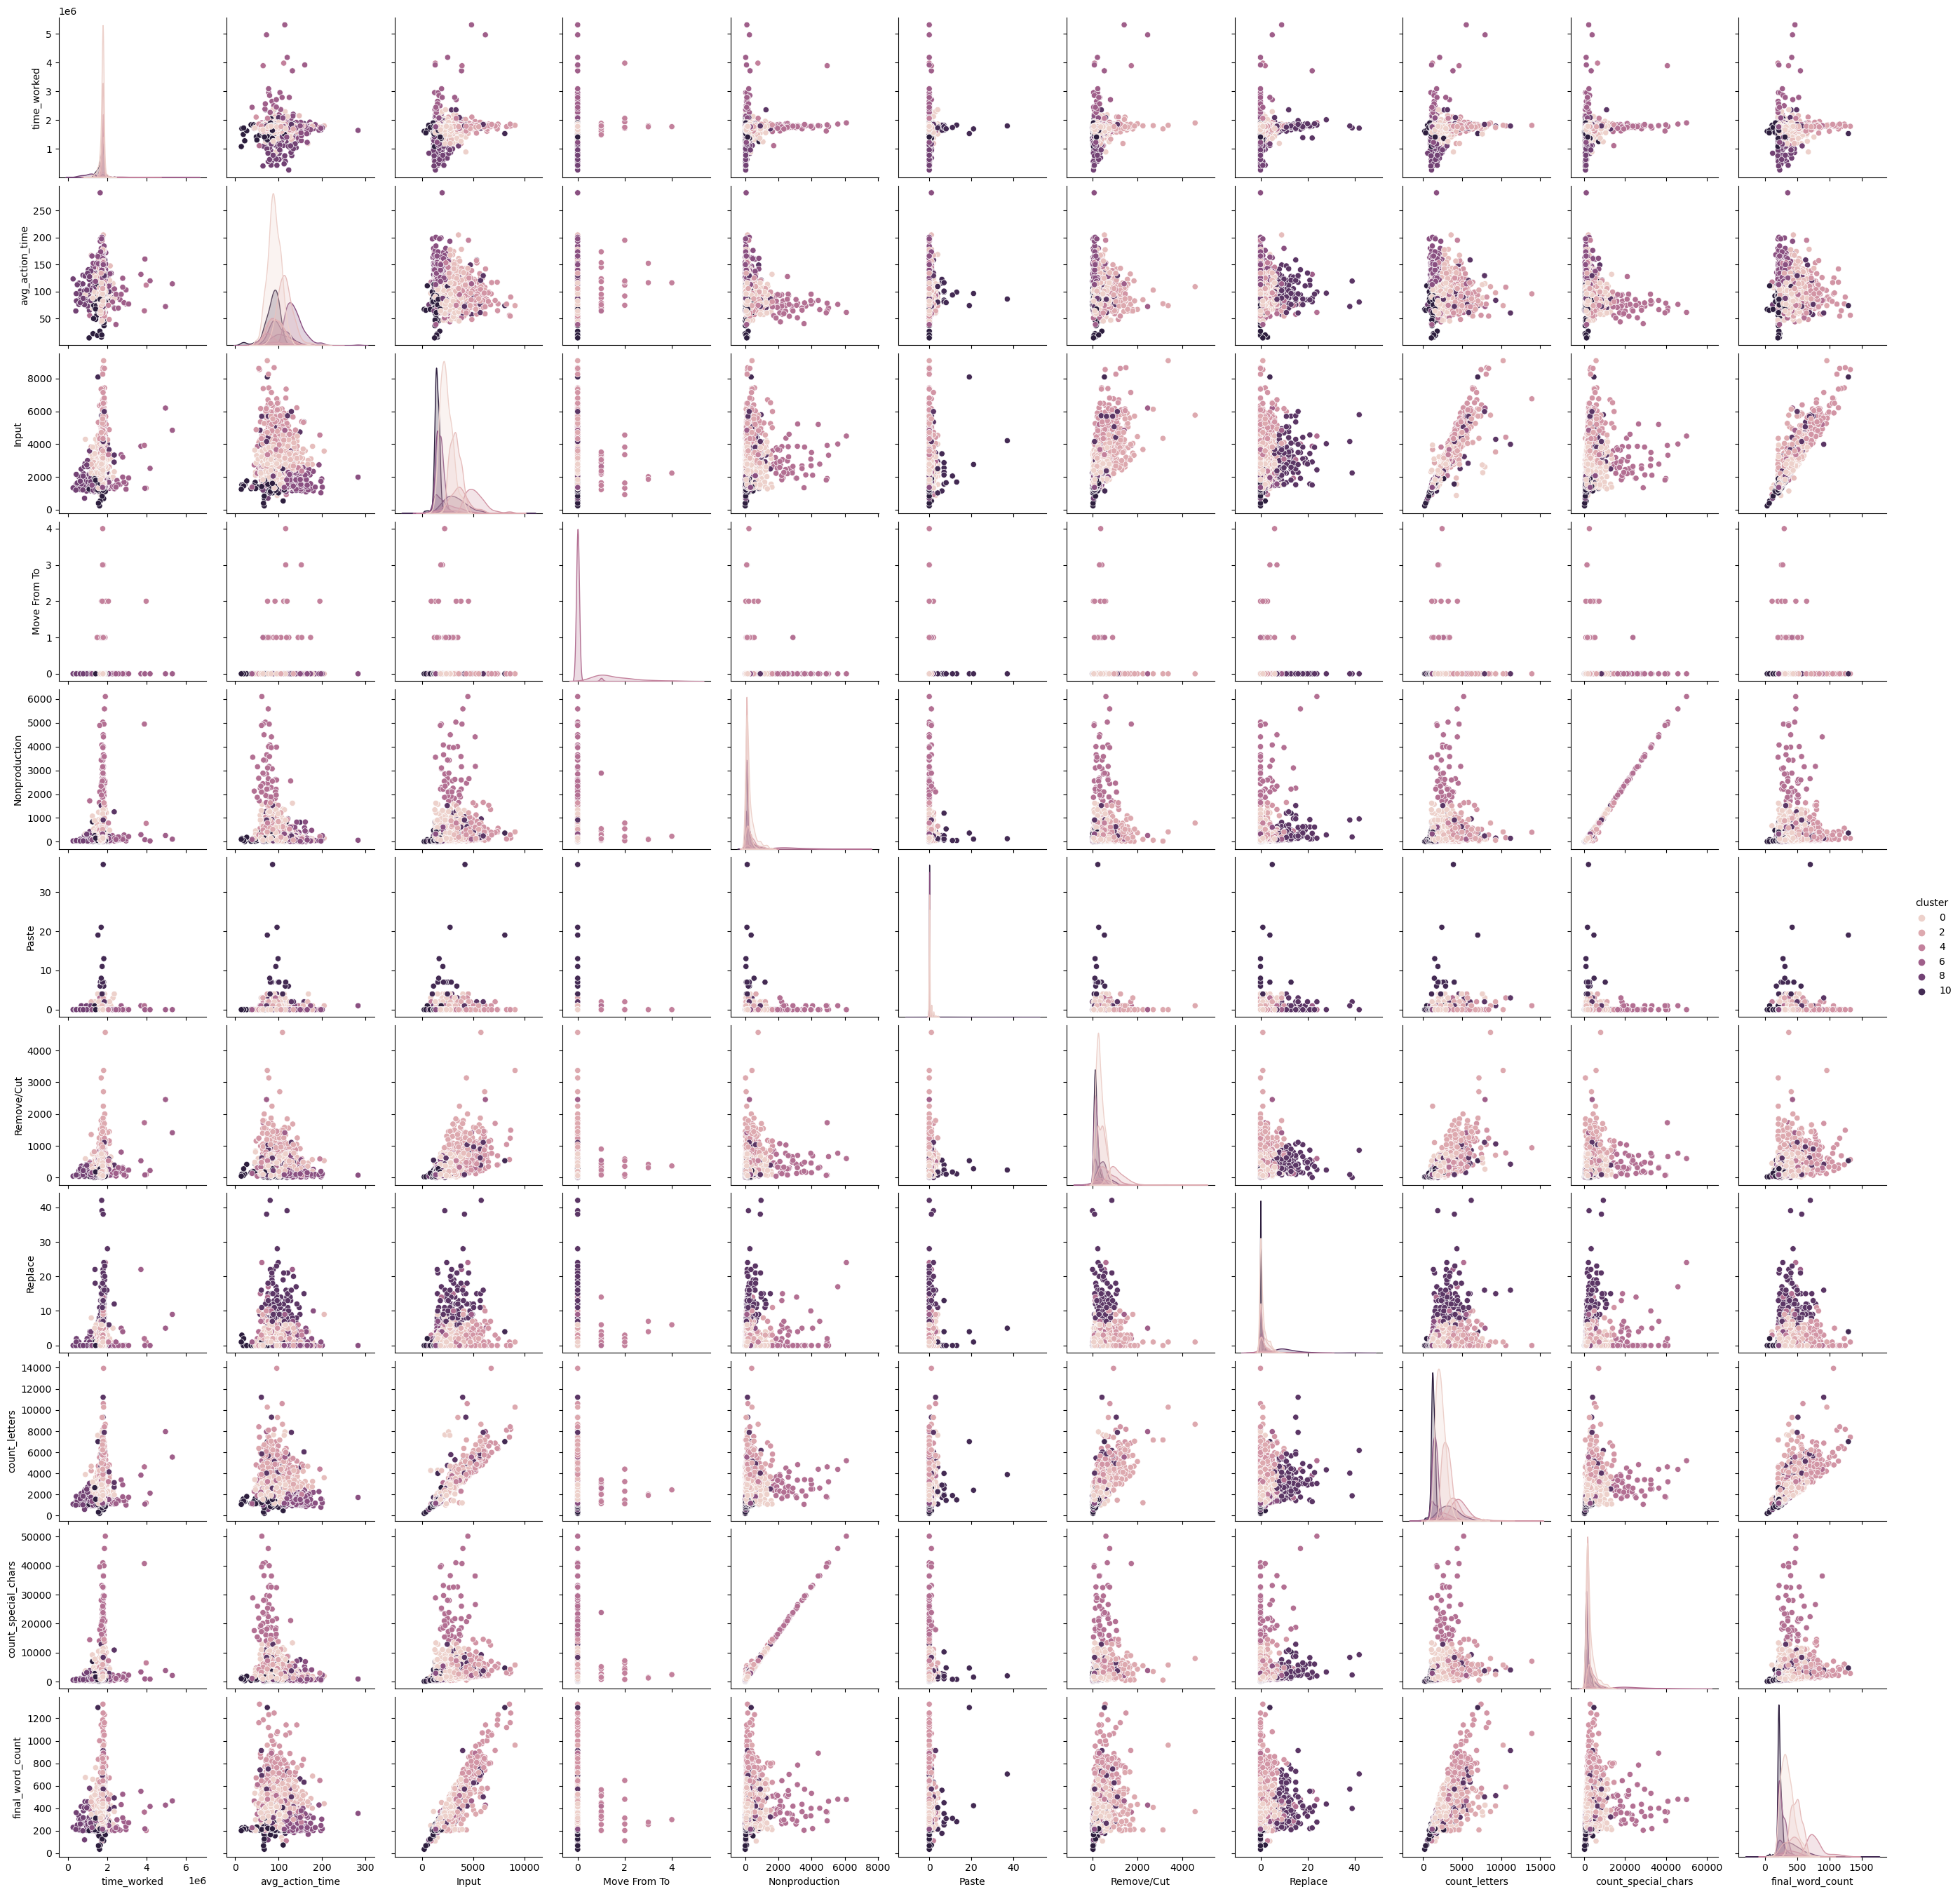

In [8]:
import pandas as pd
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(aggregated_train_data)

# Number of clusters
n_clusters = 12  # Adjust this based on your data

# Initialize and fit Spectral Clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = spectral.fit_predict(scaled_features)

# Plotting the results (if data is 2D)
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=clusters, cmap='viridis')
# plt.title('Spectral Clustering')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

#pairplot
aggregated_train_data['cluster'] = clusters
sns.pairplot(aggregated_train_data, hue='cluster')



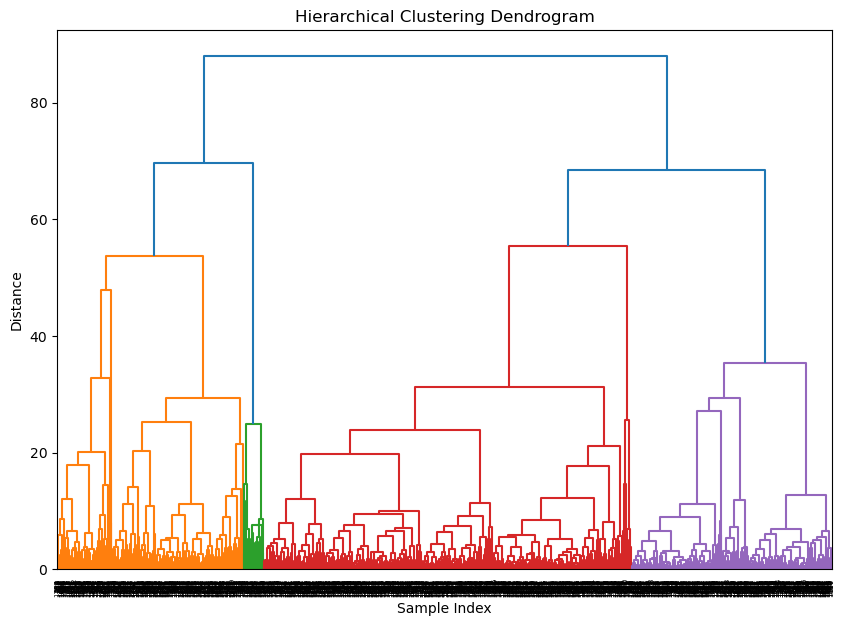

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(aggregated_train_data)

# Using linkage class from hierarchy, pass parameters
linked = linkage(scaled_features, method='ward') # 'ward' minimizes the variance of clusters being merged

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

